In [1]:
import yfinance as yahoo
import pandas as pd
import numpy as np
import scipy.optimize as sco
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
health = ['PFE','GILD','JNJ','MRK','ABT','TMO','BMY','AMGN','AZN','GSK']


In [3]:
df = yahoo.download(health,period="1y",interval="60m")['Adj Close'].fillna(method='ffill')
df = df.fillna(method='ffill')
start, end = df.iloc[0,:], df.iloc[-1,:]
renta = (end / start)
renta = renta.sort_values(axis=0,ascending=False)
renta

[*********************100%***********************]  10 of 10 completed


ABT    NaN
AMGN   NaN
AZN    NaN
BMY    NaN
GILD   NaN
GSK    NaN
JNJ    NaN
MRK    NaN
PFE    NaN
TMO    NaN
dtype: float64

In [4]:
df

,ABT,AMGN,AZN,BMY,GILD,GSK,JNJ,MRK,PFE,TMO
Datetime,,,,,,,,,,
2019-08-14 09:30:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-15 09:30:00-04:00,84.290001,199.910004,44.139999,45.674999,63.389999,39.860001,130.070007,83.230003,34.110001,274.739990
2019-08-15 10:30:00-04:00,84.180000,200.389999,44.009998,45.845001,63.459999,39.779999,129.720001,83.432899,34.146900,272.533386
2019-08-15 11:30:00-04:00,84.195000,200.520004,44.250000,45.955002,63.549999,40.030102,129.929993,83.559998,34.154999,272.924988
2019-08-15 12:30:00-04:00,84.220001,200.210007,44.195000,45.855000,63.450001,39.959999,129.850006,83.455002,34.305000,272.640015
...,...,...,...,...,...,...,...,...,...,...
2020-08-14 11:30:00-04:00,99.980003,239.470001,55.139999,63.150002,68.430000,40.570000,148.702606,84.129997,38.264999,411.880005
2020-08-14 12:30:00-04:00,100.059998,239.447800,55.165001,63.145000,68.701500,40.570000,148.580002,83.830002,38.154999,412.410004
2020-08-14 13:30:00-04:00,99.989998,238.820007,55.130001,63.049999,68.709999,40.539101,148.391205,83.860001,38.099998,411.609985


In [5]:
noa = len(df.columns) #number of assets
weights = np.random.random(noa)
weights /= np.sum(weights)
observations = 20
alpha = 0.05
mean_returns = df.pct_change().mean()
cov = df.pct_change().cov()

In [6]:
def calc_portfolio_VaR(weights, mean_returns, cov, alpha, observations):
    portfolio_return = np.sum(mean_returns * weights) * observations
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(observations)
    portfolio_var = abs(portfolio_return - (portfolio_std * stats.norm.ppf(1 - alpha)))
    return portfolio_var

def min_VaR(mean_returns, cov, alpha, observations):
    num_assets = len(mean_returns)
    args = (mean_returns, cov, alpha, observations)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (-0.3,0.3)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calc_portfolio_VaR, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result


In [7]:
min_port_VaR = min_VaR(mean_returns, cov, alpha, observations)

minimal_VaR = pd.DataFrame(index=df.columns)
minimal_VaR['weigths'] = pd.DataFrame([round(x,3) for x in min_port_VaR['x']],index=df.columns)
minimal_VaR.weigths.sort_values(axis=0,ascending=False)

JNJ     0.221
BMY     0.215
GILD    0.186
GSK     0.147
AZN     0.100
TMO     0.092
PFE     0.082
MRK     0.078
AMGN   -0.035
ABT    -0.086
Name: weigths, dtype: float64

In [8]:
portfolio = (df * minimal_VaR.weigths).T.sum()

retorno = portfolio.pct_change().cumsum()

benchmark = df.T.mean() # build an equally weigthed portfolio to use as benchmark

assets_return = df.pct_change().cumsum() # spectrum of the assets returns


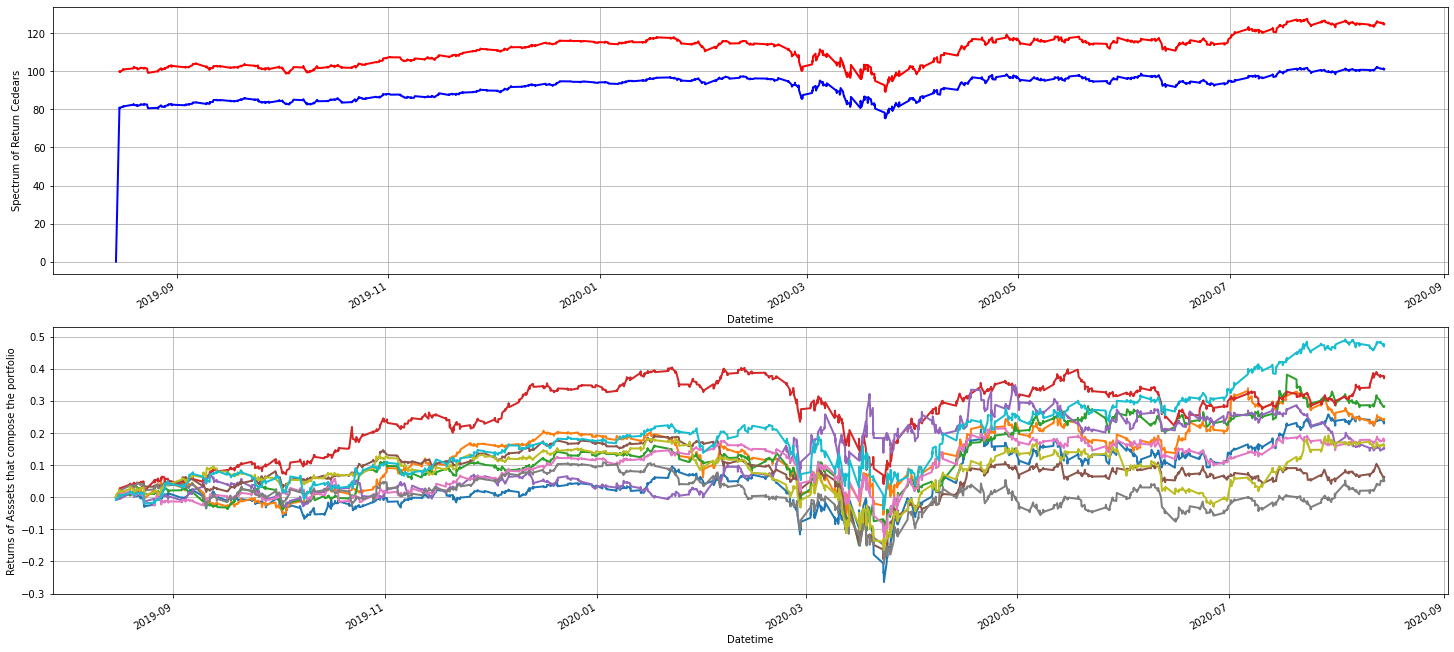

In [9]:
fig = plt.figure(figsize=(25,12))
ax1 = fig.add_subplot(211, ylabel='Spectrum of Return Cedears')
portfolio.plot(ax=ax1, color='b', lw=2.)
benchmark.plot(ax=ax1, color='r', lw=2.)
ax1.grid()
ax2 = fig.add_subplot(212, ylabel='Returns of Asssets that compose the portfolio')
assets_return.plot(ax=ax2, lw=2., legend=False)
ax2.grid()
plt.show()

In [10]:
portfolio, benchmark

(Datetime
 2019-08-14 09:30:00-04:00      0.000000
 2019-08-15 09:30:00-04:00     80.948806
 2019-08-15 10:30:00-04:00     80.704769
 2019-08-15 11:30:00-04:00     80.893097
 2019-08-15 12:30:00-04:00     80.806107
                                 ...    
 2020-08-14 11:30:00-04:00    101.259396
 2020-08-14 12:30:00-04:00    101.294462
 2020-08-14 13:30:00-04:00    101.178072
 2020-08-14 14:30:00-04:00    100.895743
 2020-08-14 15:30:00-04:00    101.264561
 Length: 1766, dtype: float64,
 Datetime
 2019-08-14 09:30:00-04:00           NaN
 2019-08-15 09:30:00-04:00     99.941500
 2019-08-15 10:30:00-04:00     99.749818
 2019-08-15 11:30:00-04:00     99.907008
 2019-08-15 12:30:00-04:00     99.814003
                                 ...    
 2020-08-14 11:30:00-04:00    124.971761
 2020-08-14 12:30:00-04:00    125.006430
 2020-08-14 13:30:00-04:00    124.820029
 2020-08-14 14:30:00-04:00    124.604721
 2020-08-14 15:30:00-04:00    125.061001
 Length: 1766, dtype: float64)

In [11]:
minimal_VaR = pd.DataFrame(index=df.columns)
minimal_VaR['weigths'] = pd.DataFrame([round(x,2) for x in min_port_VaR['x']],index=df.columns)
minimal_VaR.weigths.sort_values(axis=0,ascending=False)

JNJ     0.22
BMY     0.21
GILD    0.19
GSK     0.15
AZN     0.10
TMO     0.09
PFE     0.08
MRK     0.08
AMGN   -0.03
ABT    -0.09
Name: weigths, dtype: float64

In [12]:
portfolio = (df * minimal_VaR.weigths).T.sum()
portfolio

Datetime
2019-08-14 09:30:00-04:00      0.000000
2019-08-15 09:30:00-04:00     81.174651
2019-08-15 10:30:00-04:00     80.937739
2019-08-15 11:30:00-04:00     81.126462
2019-08-15 12:30:00-04:00     81.037852
                                ...    
2020-08-14 11:30:00-04:00    101.255773
2020-08-14 12:30:00-04:00    101.290202
2020-08-14 13:30:00-04:00    101.173329
2020-08-14 14:30:00-04:00    100.893879
2020-08-14 15:30:00-04:00    101.258201
Length: 1766, dtype: float64

In [13]:
data = df

# Calculate the returns of instruments, statistics & correlation
returns = (data - data.shift(1))/ data.shift(1)# get the returns for every serie

statistics = returns.describe().T

statistics['mad'] = returns.mad()

statistics['skew'] = returns.skew()

statistics['kurtosis'] = returns.kurtosis()

statistics = statistics.T

correlation = returns.corr() # correlation

covariance = returns.cov()  # covariance

# Calculate the deltas of the instruments as the weights assigned multiplied by their correlations (elasticity)
instruments = pd.DataFrame(index= data.columns)
instruments['weigths'] = 1/len(instruments.index) # secure allocation is equal 1
instruments['deltas'] = (instruments.weigths * correlation).sum() # deltas as elasticity of the assets
instruments['Stdev'] = returns.std()
instruments['stress'] = (instruments.deltas * instruments.Stdev) * 3 # stress applied at 4 deviations
instruments['portfolio_stress'] = instruments.stress.sum() # the stress of the portfolio

# Optional, if all the worst events happen at once, must detect the worst deviation of the instruments and apply it simultaneously
poe = (returns / returns.std()).min()
fullstress = sum(instruments.stress.multiply(poe))


In [14]:
instruments

,weigths,deltas,Stdev,stress,portfolio_stress
ABT,0.1,0.633474,0.008358,0.015883,0.139223
AMGN,0.1,0.608626,0.008396,0.015330,0.139223
AZN,0.1,0.563191,0.008170,0.013804,0.139223
BMY,0.1,0.587810,0.007657,0.013502,0.139223
GILD,0.1,0.419096,0.009174,0.011534,0.139223
GSK,0.1,0.604542,0.007081,0.012843,0.139223
JNJ,0.1,0.605957,0.007197,0.013084,0.139223
MRK,0.1,0.619928,0.007356,0.013681,0.139223
PFE,0.1,0.613792,0.007539,0.013882,0.139223
TMO,0.1,0.601889,0.008684,0.015681,0.139223


In [15]:
poe, fullstress

(ABT    -10.515811
 AMGN    -7.153858
 AZN    -15.864028
 BMY     -8.028995
 GILD    -9.811944
 GSK    -15.222620
 JNJ     -8.432351
 MRK     -7.666235
 PFE    -10.364928
 TMO     -9.924183
 dtype: float64,
 -1.4274697091089983)

In [16]:
portfolio = data.T.mean()
portfolio

Datetime
2019-08-14 09:30:00-04:00           NaN
2019-08-15 09:30:00-04:00     99.941500
2019-08-15 10:30:00-04:00     99.749818
2019-08-15 11:30:00-04:00     99.907008
2019-08-15 12:30:00-04:00     99.814003
                                ...    
2020-08-14 11:30:00-04:00    124.971761
2020-08-14 12:30:00-04:00    125.006430
2020-08-14 13:30:00-04:00    124.820029
2020-08-14 14:30:00-04:00    124.604721
2020-08-14 15:30:00-04:00    125.061001
Length: 1766, dtype: float64

In [17]:
portfolio_returns = (portfolio - portfolio.shift(1))/ portfolio.shift(1)

portfolio_stats = portfolio_returns.describe(percentiles=[.01,.05,.10]).T

portfolio_stats['var'] = portfolio_returns.var()

portfolio_stats['skew'] = portfolio_returns.skew()

portfolio_stats['Kurtosis'] = portfolio_returns.kurtosis()

In [18]:
risk = pd.DataFrame(index=data.columns)
risk['numerator'] = (instruments.deltas.multiply(covariance)).sum()
risk['denominator'] = portfolio_returns.std() * (-2.32635) # at 1% of inverse normal dist.
risk['GradVaR'] = -risk.numerator / risk.denominator
risk['CVaRj'] = risk.GradVaR * instruments.deltas # Component VaR of the Risk Factors j
risk['thetai'] = (risk.CVaRj * correlation).sum() # Theta i of the instruments
risk['CVaRi'] = risk.thetai * (1/len(data.columns)) # Component VaR of the Instruments i
risk['totalCVaRi'] = risk.CVaRi.sum() #total CVaR of the portfolio
risk['CVaRattribution'] = risk.CVaRi / risk.totalCVaRi # risk allocation by instrument in the portfolio
risk

,numerator,denominator,GradVaR,CVaRj,thetai,CVaRi,totalCVaRi,CVaRattribution
ABT,0.000266,-0.015099,0.017642,0.011176,0.070795,0.007079,0.051,0.138814
AMGN,0.000248,-0.015099,0.016421,0.009995,0.060829,0.006083,0.051,0.119274
AZN,0.000205,-0.015099,0.013566,0.007640,0.043028,0.004303,0.051,0.084370
BMY,0.000209,-0.015099,0.013826,0.008127,0.047770,0.004777,0.051,0.093668
GILD,0.000131,-0.015099,0.008695,0.003644,0.015272,0.001527,0.051,0.029945
GSK,0.000203,-0.015099,0.013448,0.008130,0.049150,0.004915,0.051,0.096373
JNJ,0.000208,-0.015099,0.013747,0.008330,0.050476,0.005048,0.051,0.098974
MRK,0.000223,-0.015099,0.014742,0.009139,0.056654,0.005665,0.051,0.111088
PFE,0.000224,-0.015099,0.014839,0.009108,0.055905,0.005590,0.051,0.109618
TMO,0.000251,-0.015099,0.016594,0.009988,0.060116,0.006012,0.051,0.117876


In [19]:
cartera = pd.DataFrame(index=data.columns)
cartera['base'] = instruments.weigths
cartera['CVaRattribution'] = risk.CVaRattribution.sort_values(axis=0,ascending=False)
cartera['new'] = minimal_VaR.weigths
cartera['condition'] = (cartera.base  * cartera.CVaRattribution)
cartera['newrisk'] = (cartera.new  * cartera.CVaRattribution)
cartera['differences'] = (cartera.newrisk - cartera.condition)  # apply this result as a percentage to multiply new weights
cartera['adjustments'] = (cartera.newrisk - cartera.condition) / cartera.condition #ALARM if its negative sum up the difference, 
                                            #if it is positive rest it, you need to have 0
cartera['suggested'] = cartera.new * (1 + cartera.adjustments)   
cartera['tototal'] = cartera.suggested.sum()
cartera['MinCVaR'] = cartera.suggested / cartera.tototal
cartera

,base,CVaRattribution,new,condition,newrisk,differences,adjustments,suggested,tototal,MinCVaR
ABT,0.1,0.138814,-0.09,0.013881,-0.012493,-0.026375,-1.9,0.081,1.91,0.042408
AMGN,0.1,0.119274,-0.03,0.011927,-0.003578,-0.015506,-1.3,0.009,1.91,0.004712
AZN,0.1,0.084370,0.10,0.008437,0.008437,0.000000,0.0,0.100,1.91,0.052356
BMY,0.1,0.093668,0.21,0.009367,0.019670,0.010303,1.1,0.441,1.91,0.230890
GILD,0.1,0.029945,0.19,0.002994,0.005690,0.002695,0.9,0.361,1.91,0.189005
GSK,0.1,0.096373,0.15,0.009637,0.014456,0.004819,0.5,0.225,1.91,0.117801
JNJ,0.1,0.098974,0.22,0.009897,0.021774,0.011877,1.2,0.484,1.91,0.253403
MRK,0.1,0.111088,0.08,0.011109,0.008887,-0.002222,-0.2,0.064,1.91,0.033508
PFE,0.1,0.109618,0.08,0.010962,0.008769,-0.002192,-0.2,0.064,1.91,0.033508
TMO,0.1,0.117876,0.09,0.011788,0.010609,-0.001179,-0.1,0.081,1.91,0.042408


In [20]:
propuesta = data * cartera.MinCVaR
propuesta = propuesta.T.sum()

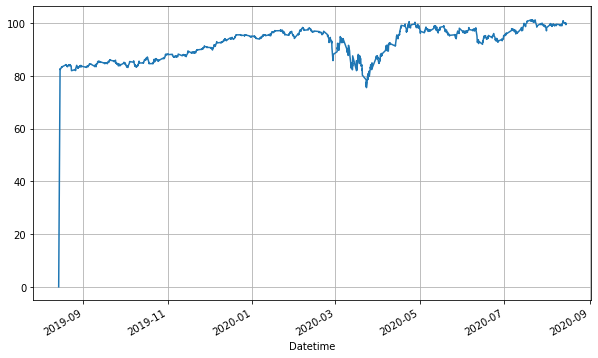

In [21]:
p = propuesta.plot(figsize=(10,6))
p.grid()

In [22]:
ponderaciones = cartera.MinCVaR.sort_values(axis=0,ascending=False)
ponderaciones.head(10)

JNJ     0.253403
BMY     0.230890
GILD    0.189005
GSK     0.117801
AZN     0.052356
TMO     0.042408
ABT     0.042408
PFE     0.033508
MRK     0.033508
AMGN    0.004712
Name: MinCVaR, dtype: float64